# Infill with silicone and SR1.5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [47]:
import os

import silicone.database_crunchers
from silicone.time_projectors import ExtendLatestTimeQuantile
import scmdata
import scmdata.database
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm.autonotebook import tqdm

from ndcs.infilling import (
    extend_timeseries,
    calc_ghg,
    kyoto_ghg_exclude_co2_vars,
    TimeDepRatio,
)  # This is for a bugfix
from ndcs.constants import (
    PROCESSED_DATA_DIR,
    NDC_TARGET_RELEASE,
    RAW_DATA_DIR,
    LEAD,
    CONTEXT,
)

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

In [5]:
GLOBAL_DATABASE_DIR = os.path.join(
    PROCESSED_DATA_DIR, "global_emissions_pathways", NDC_TARGET_RELEASE
)

<IPython.core.display.Javascript object>

In [6]:
global_db = scmdata.database.ScmDatabase(
    GLOBAL_DATABASE_DIR,
    levels=(
        "ambition",
        "conditionality",
        "country_extension",
        "exclude_hot_air",
        "pathway_id",
        "global_extension",
    ),
)
global_db

<scmdata.database.SCMDatabase (root_dir: /home/jared/code/cr/ndc-realisations-2021/src/ndcs/../../data/processed/global_emissions_pathways/12Nov2021a_CR, levels: ('ambition', 'conditionality', 'country_extension', 'exclude_hot_air', 'pathway_id', 'global_extension'))>

<IPython.core.display.Javascript object>

In [7]:
extended_scenario_all = scmdata.ScmRun(
    os.path.join(
        PROCESSED_DATA_DIR,
        "global_emissions_pathways",
        NDC_TARGET_RELEASE,
        "emissions_ghg_extended.csv",
    )
).drop_meta("global_extension")

<IPython.core.display.Javascript object>

In [8]:
extended_scenario_sample = extended_scenario_all.filter(
    scenario=extended_scenario_all.get_unique_meta("scenario")[0]
)
extended_scenario_sample

<ScmRun (timeseries: 1, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	  ambition conditionality country_extension        date exclude_hot_air last_country          model    pathway_id  pathway_num  pathway_num_today region                              scenario     stage         unit  \
	0     high              C              2030  2021-08-02         exclude          COG  NDC Factsheet  2021-08-02_1          309                  1  World  2021-08-02_1__high__C__2030__exclude  extended  Mt CO2 / yr   
	
	                                   variable  
	0  Emissions|GHG excl CO2 AFOLU (AR6GWP100)  

<IPython.core.display.Javascript object>

In [9]:
extended_scenario_sample.timeseries()

,,,,,,,,,,,,,,time,2015-01-01,2016-01-01,2017-01-01,2018-01-01,2019-01-01,2020-01-01,2021-01-01,...,2094-01-01,2095-01-01,2096-01-01,2097-01-01,2098-01-01,2099-01-01,2100-01-01
ambition,conditionality,country_extension,date,exclude_hot_air,last_country,model,pathway_id,pathway_num,pathway_num_today,region,scenario,stage,unit,variable,,,,,,,,,,,,,,,
high,C,2030,2021-08-02,exclude,COG,NDC Factsheet,2021-08-02_1,309,1,World,2021-08-02_1__high__C__2030__exclude,extended,Mt CO2 / yr,Emissions|GHG excl CO2 AFOLU (AR6GWP100),50801.212705,50904.230828,51561.060711,52365.200699,52682.002397,52672.554015,52708.680202,...,23224.117233,22908.040193,22608.846594,22308.833287,22009.639688,21710.446089,21411.25249


<IPython.core.display.Javascript object>

In [10]:
sr15_data_cleaned = scmdata.ScmRun(os.path.join(PROCESSED_DATA_DIR, "sr15_data.csv"))

<IPython.core.display.Javascript object>

In [11]:
sr15_data_cleaned

<ScmRun (timeseries: 10686, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      climate_model                                       id              model region                scenario       stage todo         unit                                  variable
	0       unspecified           AIM_2_0_ADVANCE_2020_1.5C-2100            AIM_2_0  World  ADVANCE_2020_1.5C-2100  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	1       unspecified               AIM_2_0_ADVANCE_2020_Med2C            AIM_2_0  World      ADVANCE_2020_Med2C  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	2       unspecified                AIM_2_0_ADVANCE_2020_WB2C            AIM_2_0  World       ADVANCE_2020_WB2C  harmonised  SET  Mt CO2 / yr  Emissions|GHG excl CO2 AFOLU (AR6GWP100)
	3       unspecified               AIM_2_0_ADVANCE_2030_Med2C            AIM_2_0  World      ADVANCE_2030_Med2C  harmonised  SET  Mt CO2 / yr  Emissions|

<IPython.core.display.Javascript object>

In [12]:
def calc_cum_emis(emis, zero_year=2020):
    cum_emissions = emis.integrate().relative_to_ref_period_mean(year=zero_year)

    return cum_emissions.convert_unit("Gt CO2")

<IPython.core.display.Javascript object>

In [13]:
def generate_percentage_differences(inp):
    df = inp.filter(year=2100).timeseries()
    
    df_2 = df.unstack("stage").sort_index()
    df_2.index = df_2.index.droplevel(
        level=list(set(df_2.index.names) - {"scenario", "stage"})
    )
    df_2.columns = df_2.columns.get_level_values("stage")
    
    df_pct_change = df_2.pct_change(axis=1).iloc[:, -1]
    df_pct_change.name = "pct_change"
    return df_pct_change


<IPython.core.display.Javascript object>

# Check how well infilling should work

In [14]:
median_sr15 = sr15_data_cleaned.quantiles_over(
    ("id", "model", "scenario"), [0.1, 0.25, 0.5, 0.75, 0.9]
)
median_sr15["scenario"] = "SR15 median"
median_sr15["model"] = "not_applicable"
median_sr15 = scmdata.ScmRun(median_sr15)
median_sr15["scenario"] = ["SR15 median " + str(q) for q in median_sr15["quantile"]]
median_sr15

<ScmRun (timeseries: 130, timepoints: 86)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	    climate_model           model  quantile region         scenario       stage todo                unit                                    variable
	0     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET          Mt BC / yr                                Emissions|BC
	1     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET         Mt CH4 / yr                               Emissions|CH4
	2     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET          Mt CO / yr                                Emissions|CO
	3     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET         Mt CO2 / yr                  Emissions|CO2|MAGICC AFOLU
	4     unspecified  not_applicable       0.1  World  SR15 median 0.1  harmonised  SET         Mt CO2 / yr  Emissions|CO2|MAGICC Fossil and In

<IPython.core.display.Javascript object>

In [15]:
median_sr15_ghg = calc_ghg(median_sr15, kyoto_ghg_exclude_co2_vars)
median_sr15_ghg["stage"] = "single"

<IPython.core.display.Javascript object>

In [16]:
data_of_interest = scmdata.run_append(
    [
        median_sr15_ghg,
        median_sr15.filter(variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)"),
    ]
)

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 / yr'>

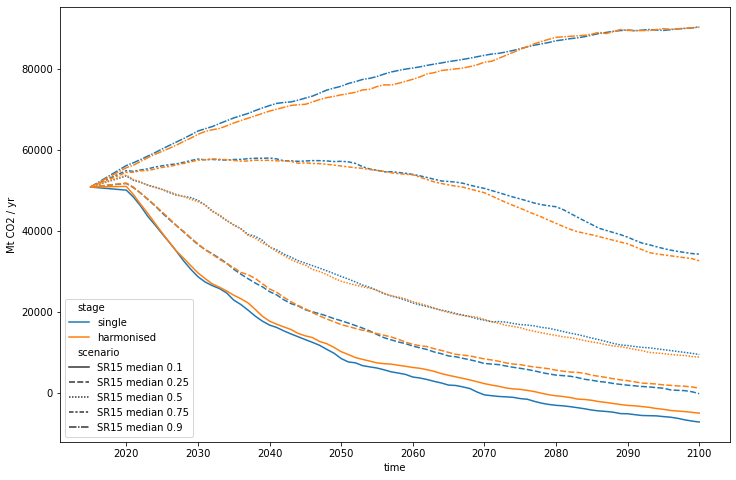

<IPython.core.display.Javascript object>

In [17]:
data_of_interest.lineplot(hue="stage", style="scenario")

In [18]:
generate_percentage_differences(calc_cum_emis(data_of_interest))

scenario
SR15 median 0.1    -0.156276
SR15 median 0.25   -0.032854
SR15 median 0.5     0.017501
SR15 median 0.75    0.022740
SR15 median 0.9     0.013075
Name: pct_change, dtype: float64

<IPython.core.display.Javascript object>

# Infill other gases
We now have a scenario extended to 2100, now we need to split the GHG emissions into individual species

In [111]:
magicc_required_variables = [
    "Emissions|BC",
    "Emissions|C2F6",
    "Emissions|C6F14",
    "Emissions|CF4",
    "Emissions|CH4",
    "Emissions|CO",
    "Emissions|CO2|MAGICC AFOLU",
    "Emissions|CO2|MAGICC Fossil and Industrial",
    "Emissions|HFC125",
    "Emissions|HFC134a",
    "Emissions|HFC143a",
    "Emissions|HFC227ea",
    "Emissions|HFC23",
    "Emissions|HFC245fa",
    "Emissions|HFC32",
    "Emissions|HFC4310",
    "Emissions|N2O",
    "Emissions|NH3",
    "Emissions|NMVOC",
    "Emissions|NOx",
    "Emissions|OC",
    "Emissions|SF6",
    "Emissions|SOx",
]

# Order matters
# (name, cruncher, subtract_from_lead, variables_to_infill)
cruncher_config = [
    # Infill the important GHG gases
    (
        "CO2I",
        LEAD,
        silicone.database_crunchers.QuantileRollingWindows,
        {"nwindows": 81, "decay_length_factor": 0.5},
        False,
        [
            "Emissions|CO2|MAGICC Fossil and Industrial",
        ],
    ),
    (
        "MajorGHG",
        LEAD,
        silicone.database_crunchers.QuantileRollingWindows,
        {"nwindows": 51, "decay_length_factor": 1},
        False,
        [
            "Emissions|CH4",
            "Emissions|N2O",
        ],
    ),
    (
        "FGases",
        "Emissions|CO2|MAGICC Fossil and Industrial",
        # Maybe use RMSClosest
        TimeDepRatio,
        {},
        #         {"nwindows": 101, "decay_length_factor": 1},
        False,
        [
            "Emissions|CF4",
            "Emissions|C2F6",
            "Emissions|C6F14",
            "Emissions|HFC134a",
            "Emissions|HFC143a",
            "Emissions|HFC227ea",
            "Emissions|HFC23",
            "Emissions|HFC32",
            "Emissions|HFC4310",
            "Emissions|HFC245fa",
            "Emissions|HFC125",
            "Emissions|SF6",
        ],
    ),
    # Infill any aerosol precursors
    (
        "AerosolPrecursors",
        "Emissions|CO2|MAGICC Fossil and Industrial",
        TimeDepRatio,
        {},
        #         {"nwindows": 81, "decay_length_factor": 0.2},
        False,
        [
            "Emissions|BC",
            "Emissions|CO",
            "Emissions|NH3",
            "Emissions|NOx",
            "Emissions|OC",
            "Emissions|SOx",
            "Emissions|NMVOC",
        ],
    ),
]


infilled_later = [
    "Emissions|CO2|MAGICC AFOLU",  #  SSP2-1.9 (L37 in Harmonisation LandUse sheet)
]

# Check that we cover all required variable for MAGICC
infilled_variables = [item for sublist in cruncher_config for item in sublist[-1]]
assert sorted(magicc_required_variables) == sorted(
    infilled_variables + infilled_later
), set(magicc_required_variables) - set(infilled_variables + infilled_later)

<IPython.core.display.Javascript object>

In [112]:
YEARS_TO_INFILL = [2015] + list(range(2020, 2100 + 1, 5))
YEARS_TO_INFILL

[2015,
 2020,
 2025,
 2030,
 2035,
 2040,
 2045,
 2050,
 2055,
 2060,
 2065,
 2070,
 2075,
 2080,
 2085,
 2090,
 2095,
 2100]

<IPython.core.display.Javascript object>

In [113]:
infilling_database = sr15_data_cleaned.filter(year=YEARS_TO_INFILL)

<IPython.core.display.Javascript object>

In [114]:
def _subtract(df, lead_var, new_lead_var, variables_to_subtract):
    run = scmdata.ScmRun(df)

    existing_lead = run.filter(variable=lead_var)
    added_variables = run.filter(variable=variables_to_subtract)

    added_ghg = calc_ghg(
        added_variables, var_name="GHG", include_vars=variables_to_subtract
    )

    lead_minus_others = existing_lead.subtract(
        added_ghg, op_cols={"variable": new_lead_var}
    )

    lead_minus_others["variable"] = new_lead_var
    return lead_minus_others


def infill_scenarios(scenario):
    infilling_database = (
        sr15_data_cleaned.filter(year=YEARS_TO_INFILL).copy().to_iamdataframe()
    )
    infilled_scenario = scenario.filter(year=YEARS_TO_INFILL).copy().to_iamdataframe()

    for config in tqdm(cruncher_config, desc="Cruncher", leave=False):
        (
            name,
            lead_var,
            cruncher_cls,
            params,
            subtract_from_lead,
            variables_to_infill,
        ) = config

        cruncher = cruncher_cls(infilling_database)
        for variable in tqdm(variables_to_infill, desc="Variable", leave=False):
            infiller = cruncher.derive_relationship(variable, [lead_var], **params)

            infilled = infiller(infilled_scenario)
            infilled_scenario.append(infilled, inplace=True)

            if subtract_from_lead:
                # subtract the added emissions from the lead
                new_lead_var = lead_var + "|" + name

                # Subtract a subset of variables from the lead variable
                new_lead_database = _subtract(
                    infilling_database, lead_var, new_lead_var, variables_to_infill
                )
                new_lead_scenario = _subtract(
                    infilled_scenario, lead_var, new_lead_var, variables_to_infill
                )

                # Merge into database
                infilling_database = scmdata.run_append(
                    [scmdata.ScmRun(infilling_database), new_lead_database]
                ).to_iamdataframe()

                infilled_scenario = scmdata.run_append(
                    [scmdata.ScmRun(infilled_scenario), new_lead_scenario]
                ).to_iamdataframe()

                lead_var = new_lead_var
    return scmdata.ScmRun(infilled_scenario)


infilled_scenario = infill_scenarios(extended_scenario_sample)

Cruncher:   0%|          | 0/4 [00:00<?, ?it/s]

Variable:   0%|          | 0/1 [00:00<?, ?it/s]

Variable:   0%|          | 0/2 [00:00<?, ?it/s]

Variable:   0%|          | 0/12 [00:00<?, ?it/s]

Variable:   0%|          | 0/7 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [115]:
infilled_scenario.get_unique_meta("variable")

['Emissions|BC',
 'Emissions|C2F6',
 'Emissions|C6F14',
 'Emissions|CF4',
 'Emissions|CH4',
 'Emissions|CO',
 'Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|GHG excl CO2 AFOLU (AR6GWP100)',
 'Emissions|HFC125',
 'Emissions|HFC134a',
 'Emissions|HFC143a',
 'Emissions|HFC227ea',
 'Emissions|HFC23',
 'Emissions|HFC245fa',
 'Emissions|HFC32',
 'Emissions|HFC4310',
 'Emissions|N2O',
 'Emissions|NH3',
 'Emissions|NMVOC',
 'Emissions|NOx',
 'Emissions|OC',
 'Emissions|SF6',
 'Emissions|SOx']

<IPython.core.display.Javascript object>

# Check the infilling

In [116]:
infilled_scenario.filter(
    variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)"
).timeseries()

,,,,,,,,,,,,,,time,2015-01-01,2020-01-01,2025-01-01,2030-01-01,2035-01-01,2040-01-01,2045-01-01,...,2070-01-01,2075-01-01,2080-01-01,2085-01-01,2090-01-01,2095-01-01,2100-01-01
ambition,conditionality,country_extension,date,exclude_hot_air,last_country,model,pathway_id,pathway_num,pathway_num_today,region,scenario,stage,unit,variable,,,,,,,,,,,,,,,
high,C,2030,2021-08-02,exclude,COG,NDC Factsheet,2021-08-02_1,309,1,World,2021-08-02_1__high__C__2030__exclude,extended,Mt CO2 / yr,Emissions|GHG excl CO2 AFOLU (AR6GWP100),50801.212705,52672.554015,52835.597728,51580.731913,50312.63958,49044.547246,47775.760448,...,32166.705904,29837.792762,28081.458169,26101.688406,24489.291359,22908.040193,21411.25249


<IPython.core.display.Javascript object>

In [117]:
infilled_scenario_ghg = calc_ghg(
    infilled_scenario, include_vars=kyoto_ghg_exclude_co2_vars, context=CONTEXT
)
infilled_scenario_ghg["stage"] = "infilled"

<IPython.core.display.Javascript object>

<AxesSubplot:title={'center':'Emissions|GHG excl CO2 AFOLU (AR6GWP100)'}, xlabel='time', ylabel='Mt CO2 / yr'>

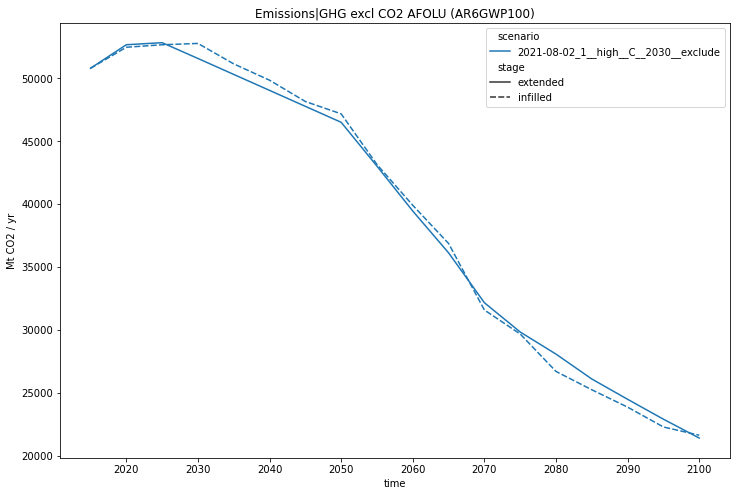

<IPython.core.display.Javascript object>

In [118]:
plt.title("Emissions|GHG excl CO2 AFOLU (AR6GWP100)")
scmdata.run_append(
    [
        infilled_scenario.filter(variable=LEAD),
        infilled_scenario_ghg,
    ]
).lineplot(hue="scenario", style="stage")

In [119]:
cum_ghg_emis = calc_cum_emis(
    scmdata.run_append(
        [
            infilled_scenario.filter(variable=LEAD),
            infilled_scenario_ghg,
        ]
    )
    .filter(year=range(2020, 2101))
    .resample("AS")
)

<IPython.core.display.Javascript object>

In [120]:
generate_percentage_differences(cum_ghg_emis)

scenario
2021-08-02_1__high__C__2030__exclude    0.001395
Name: pct_change, dtype: float64

<IPython.core.display.Javascript object>

In [121]:
infilled_scenario.filter(
    variable="Emissions|GHG excl CO2 AFOLU (AR6GWP100)*"
).timeseries()

,,,,,,,,,,,,,,time,2015-01-01,2020-01-01,2025-01-01,2030-01-01,2035-01-01,2040-01-01,2045-01-01,...,2070-01-01,2075-01-01,2080-01-01,2085-01-01,2090-01-01,2095-01-01,2100-01-01
ambition,conditionality,country_extension,date,exclude_hot_air,last_country,model,pathway_id,pathway_num,pathway_num_today,region,scenario,stage,unit,variable,,,,,,,,,,,,,,,
high,C,2030,2021-08-02,exclude,COG,NDC Factsheet,2021-08-02_1,309,1,World,2021-08-02_1__high__C__2030__exclude,extended,Mt CO2 / yr,Emissions|GHG excl CO2 AFOLU (AR6GWP100),50801.212705,52672.554015,52835.597728,51580.731913,50312.63958,49044.547246,47775.760448,...,32166.705904,29837.792762,28081.458169,26101.688406,24489.291359,22908.040193,21411.25249


<IPython.core.display.Javascript object>

In [122]:
infilled_scenarios_all = infill_scenarios(extended_scenario_all)

Cruncher:   0%|          | 0/4 [00:00<?, ?it/s]

Variable:   0%|          | 0/1 [00:00<?, ?it/s]

Variable:   0%|          | 0/2 [00:00<?, ?it/s]

Variable:   0%|          | 0/12 [00:00<?, ?it/s]

Variable:   0%|          | 0/7 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [123]:
infilled_scenarios_ghg_all = calc_ghg(
    infilled_scenarios_all, include_vars=kyoto_ghg_exclude_co2_vars, context=CONTEXT
)
infilled_scenarios_ghg_all["stage"] = "infilled"
cum_ghg_emis_all = calc_cum_emis(
    scmdata.run_append(
        [
            infilled_scenarios_all.filter(variable=LEAD),
            infilled_scenarios_ghg_all,
        ]
    )
    .filter(year=range(2020, 2101))
    .resample("AS")
)
pct_diffs = generate_percentage_differences(cum_ghg_emis_all)
pct_diffs

scenario
2013-07-18_1__high__C__2030__exclude       0.007318
2013-07-18_2__high__C__2030__exclude       0.006758
2013-07-18_3__high__C__2030__exclude       0.005732
2015-08-05_1__high__C__2030__exclude       0.005704
2015-09-26_1__high__C__2030__exclude       0.005659
2015-09-30_1__high__C__2030__exclude       0.005659
2015-09-30_2__high__C__2030__exclude       0.006296
2015-10-01_1__high__C__2030__exclude       0.006153
2015-10-01_2__high__C__2030__exclude       0.006578
2015-11-12_1__high__C__2030__exclude       0.004722
                                             ...   
2021-10-28_2__low__U__SSP1BL__exclude      0.001952
2021-10-30_1__low__U__SSP1BL__exclude      0.001952
2021-11-01_1__low__U__SSP1BL__exclude     -0.006517
2021-11-03_1__low__U__SSP1BL__exclude     -0.006509
2021-11-09_1__low__U__SSP1BL__exclude     -0.006506
2021-11-09_1__low__U__SSP1BL__include      0.005412
2021-11-09_1__low__U__constant__exclude   -0.003572
2021-11-09_1__low__U__constant__include   -0.005009
202

<IPython.core.display.Javascript object>

In [124]:
pct_diffs.describe()

count    2872.000000
mean       -0.000217
std         0.005765
min        -0.017532
25%        -0.003373
50%        -0.000166
75%         0.005174
max         0.011307
Name: pct_change, dtype: float64

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='extended', ylabel='pct_change'>

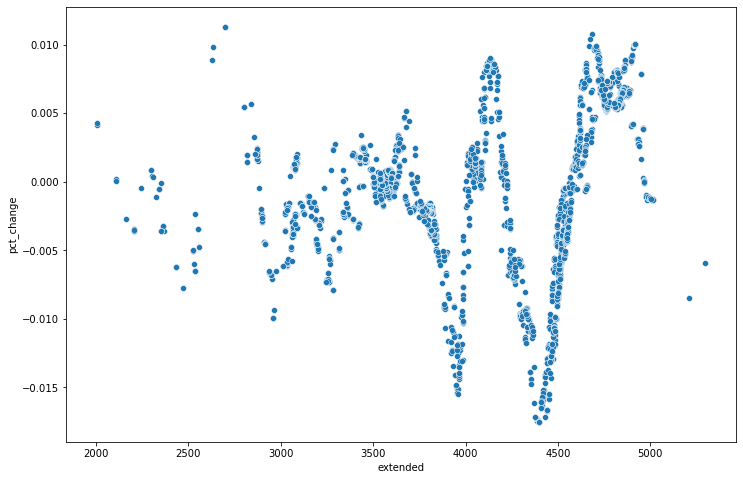

<IPython.core.display.Javascript object>

In [126]:
for_seaborn = cum_ghg_emis_all.filter(year=2100).timeseries().unstack("stage")
for_seaborn.columns = for_seaborn.columns.get_level_values("stage")
for_seaborn.index = for_seaborn.index.get_level_values("scenario")

for_seaborn = pd.merge(for_seaborn, pct_diffs, left_index=True, right_index=True)

sns.scatterplot(data=for_seaborn, x="extended", y="pct_change")

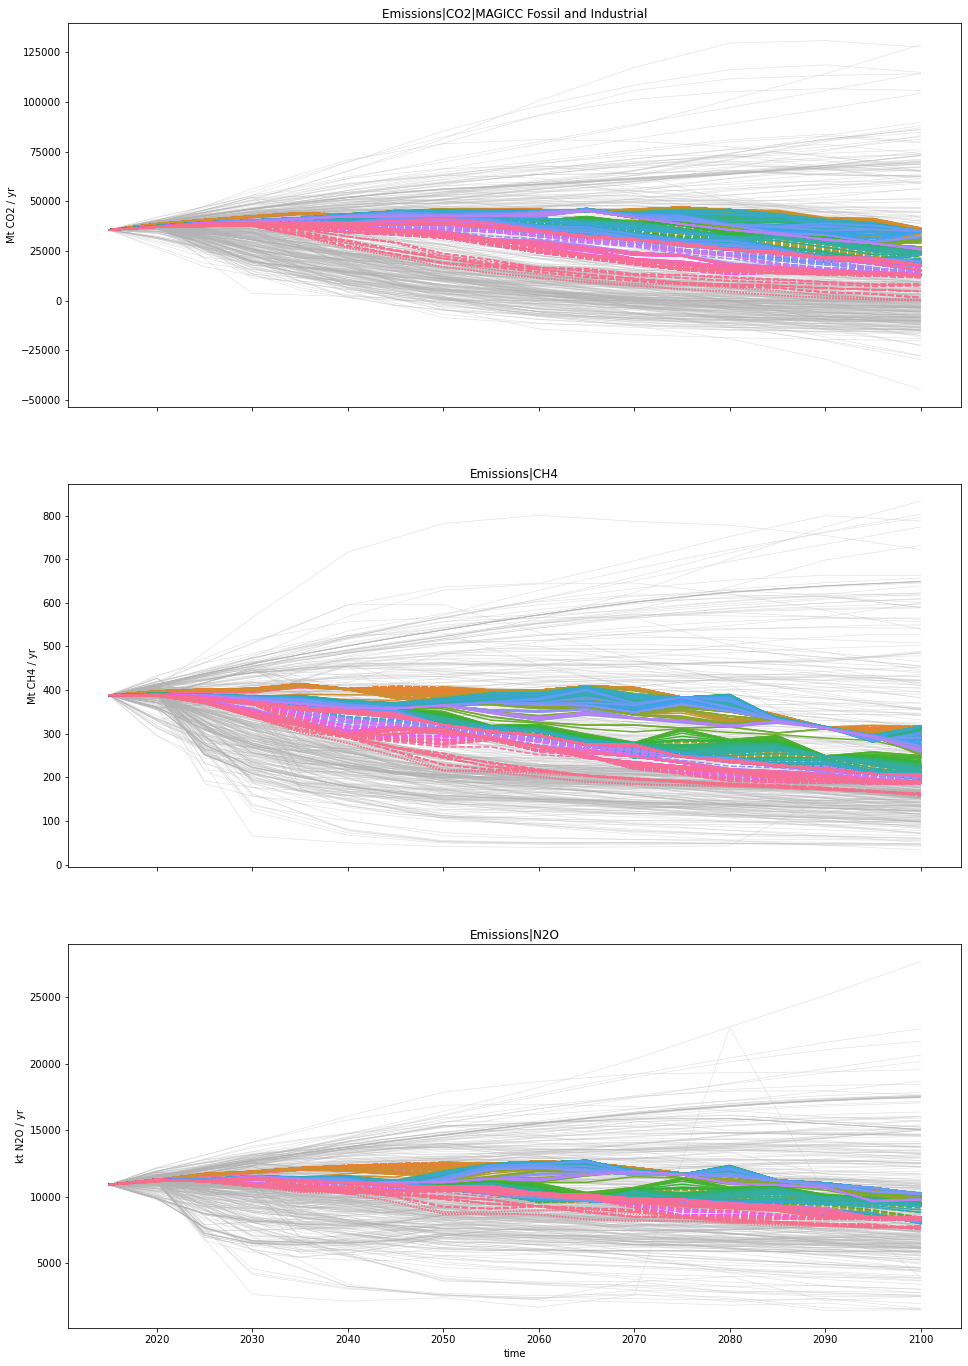

<IPython.core.display.Javascript object>

In [127]:
num_plots = 3

fig = plt.figure(figsize=(16, 8 * num_plots))
axs = fig.subplots(num_plots, sharex=True)

for i, v in enumerate(infilled_variables[:num_plots]):
    ax = axs[i]
    pkwargs = {
        "hue": None,
        "color": "0.7",
        "lw": 0.6,
        "alpha": 0.4,
        "units": "id",
        "estimator": None,
        "legend": False,
    }

    sr15_data_cleaned.filter(year=YEARS_TO_INFILL, variable=v).lineplot(
        ax=ax, **pkwargs
    )
    infilled_scenarios_all.filter(
        variable=v, exclude_hot_air="exclude", ambition="high"
    ).lineplot(
        ax=ax,
        legend=False,
        style="country_extension",
        units="scenario",
        estimator=None,
    )
    ax.set_title(v)

In [129]:
infilled_scenarios_all.head()

time                                                                                                                                                                                                                           2015-01-01  2020-01-01  \
ambition conditionality country_extension date       exclude_hot_air last_country model         pathway_id   pathway_num pathway_num_today region scenario                             stage    unit          variable                                  
high     C              2030              2013-07-18 exclude         LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__2030__exclude extended Mt BC / yr    Emissions|BC        9.72742    9.375705   
                                                                                                                                                                                                kt C2F6 / yr  Emissions|C2F6      1.57000    2.571007   
                                                                                                                                                                                                kt C6F14 / yr Emissions|C6F14     0.35000    0.238191   
                                                                                                                                                                                                kt CF4 / yr   Emissions|CF4      10.86990   12.661761   
                                                                                                                                                                                                Mt CH4 / yr   Emissions|CH4     388.07300  397.870968   

time                                                                                                                                                                                                                           2025-01-01  2030-01-01  \
ambition conditionality country_extension date       exclude_hot_air last_country model         pathway_id   pathway_num pathway_num_today region scenario                             stage    unit          variable                                  
high     C              2030              2013-07-18 exclude         LBY          NDC Factsheet 2013-07-18_1 1           1                 World  2013-07-18_1__high__C__2030__exclude extended Mt BC / yr    Emissions|BC       9.339140    9.271916   
                                                                                                                                                                                                kt C2F6 / yr  Emissions|C2F6     1.827147    1.018964   
                                                                                                                                                                                                kt C6F14 / yr Emissions|C6F14    0.199088    0.161352   
                                                                                                                                                                                                kt CF4 / yr   Emissions|CF4     10.380459    8.479075   
                                                                                                                                                                                                Mt CH4 / yr   Emissions|CH4    394.123966  394.302143   

time                                                                                                                                                                                                                           2035-01-01  2040-01-01  \
ambition conditionality country_extension date       exclude_hot_air last_country model         pathway_id   pathway_num pathway_num_today region scenario                             stage    unit          variable                                  
high     C    

<IPython.core.display.Javascript object>

## Add AFOLU

In [130]:
AFOLU_SELECTED_SCENARIO = "Adjusted NDCs FOLU (SSP1-1.9)"

<IPython.core.display.Javascript object>

In [131]:
afolu = scmdata.ScmRun(
    os.path.join(
        PROCESSED_DATA_DIR, "global_emissions", NDC_TARGET_RELEASE, "landuse.csv"
    )
).convert_unit("Mt CO2 / yr")
afolu

<ScmRun (timeseries: 7, timepoints: 71)>
Time:
	Start: 1980-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	           model region                       scenario         unit        variable
	0  NDC Factsheet  World  Adjusted NDCs FOLU (SSP1-1.9)  Mt CO2 / yr  Emissions|FOLU
	1  NDC Factsheet  World  Adjusted NDCs FOLU (SSP1-2.6)  Mt CO2 / yr  Emissions|FOLU
	2  NDC Factsheet  World  Adjusted NDCs FOLU (SSP2-4.5)  Mt CO2 / yr  Emissions|FOLU
	3  NDC Factsheet  World          Global Carbon Project  Mt CO2 / yr  Emissions|FOLU
	4  NDC Factsheet  World                       SSP1-1.9  Mt CO2 / yr  Emissions|FOLU
	5  NDC Factsheet  World                       SSP1-2.6  Mt CO2 / yr  Emissions|FOLU
	6  NDC Factsheet  World                       SSP2-4.5  Mt CO2 / yr  Emissions|FOLU

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='time', ylabel='Mt CO2 / yr'>

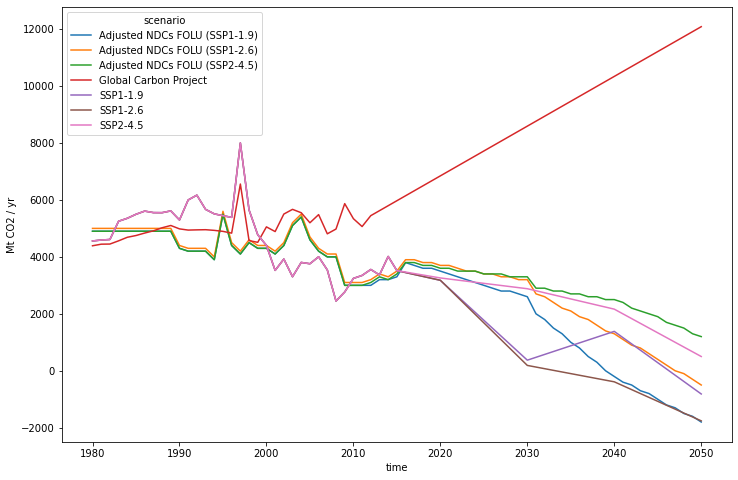

<IPython.core.display.Javascript object>

In [132]:
afolu.lineplot(hue="scenario")

In [133]:
selected_afolu = afolu.filter(
    scenario=AFOLU_SELECTED_SCENARIO, year=range(2000, 2101)
).convert_unit("Mt CO2 / yr")
selected_afolu["variable"] = "Emission|CO2|MAGICC AFOLU"
selected_afolu

<ScmRun (timeseries: 1, timepoints: 51)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2050-01-01T00:00:00
Meta:
	           model region                       scenario         unit                   variable
	0  NDC Factsheet  World  Adjusted NDCs FOLU (SSP1-1.9)  Mt CO2 / yr  Emission|CO2|MAGICC AFOLU

<IPython.core.display.Javascript object>

In [134]:
sr15_afolu = sr15_data_cleaned.filter(
    variable="Emissions|CO2|MAGICC AFOLU"
).convert_unit("Mt CO2 / yr")

<IPython.core.display.Javascript object>

In [135]:
extended_afolu = extend_timeseries(
    sr15_afolu, selected_afolu, lead="Emissions|CO2|MAGICC AFOLU"
)
extended_afolu

<ScmRun (timeseries: 1, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	           model region                       scenario     stage         unit                    variable
	0  NDC Factsheet  World  Adjusted NDCs FOLU (SSP1-1.9)  extended  Mt CO2 / yr  Emissions|CO2|MAGICC AFOLU

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Database CO$_2$|AFOLU and lead emissions timeseries')

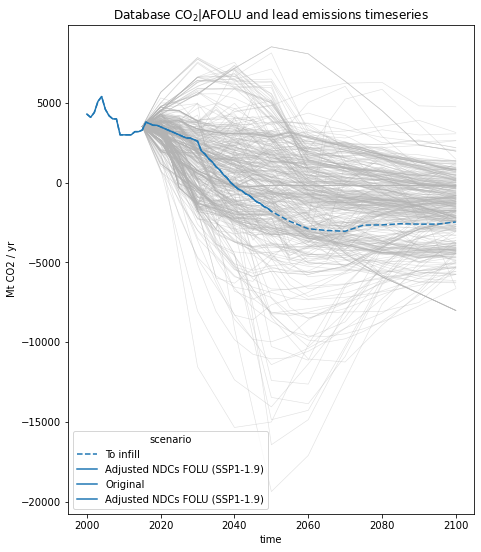

<IPython.core.display.Javascript object>

In [136]:
pkwargs = {
    "hue": None,
    "color": "0.7",
    "lw": 0.6,
    "alpha": 0.4,
    "units": "id",
    "estimator": None,
    "legend": False,
}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)

sr15_afolu.lineplot(ax=ax, **pkwargs)
extended_afolu.lineplot(ax=ax, linestyle="--", dashes=(10, 15), label="To infill")
selected_afolu.lineplot(ax=ax, label="Original")
ax.set_title("Database CO$_2$|AFOLU and lead emissions timeseries")

In [137]:
def add_afolu(scenario):
    infilled_scenario_complete = (
        scenario.append(extended_afolu).filter(year=range(2000, 2101)).resample("AS")
    )
    infilled_scenario_complete["global_extension"] = "silicone"
    infilled_scenario_complete["ambition"] = scenario.get_unique_meta("ambition")
    infilled_scenario_complete["conditionality"] = scenario.get_unique_meta(
        "conditionality"
    )
    infilled_scenario_complete["exclude_hot_air"] = scenario.get_unique_meta(
        "exclude_hot_air"
    )
    infilled_scenario_complete["country_extension"] = scenario.get_unique_meta(
        "country_extension"
    )
    infilled_scenario_complete["pathway_id"] = scenario.get_unique_meta("pathway_id")
    infilled_scenario_complete["stage"] = "infilled"

    infilled_scenario_complete["scenario"] = scenario.get_unique_meta("scenario")

    return infilled_scenario_complete

<IPython.core.display.Javascript object>

In [138]:
infilled_scenarios_complete_all = []

for infilled_scenario in tqdm(
    infilled_scenarios_all.groupby(
        [
            "ambition",
            "conditionality",
            "country_extension",
            "exclude_hot_air",
            "pathway_id",
        ]
    )
):
    infilled_scenario_complete = add_afolu(infilled_scenario)
    infilled_scenarios_complete_all.append(infilled_scenario_complete)

infilled_scenarios_complete_all = scmdata.run_append(infilled_scenarios_complete_all)

0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

In [139]:
infilled_scenario_complete.timeseries()

time                                                                                                                                                                                                                                                                             2000-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                            stage    unit               variable                                                   
low      U              rate              2021-11-09 include         silicone         VEN          NDC Factsheet 2021-11-09_1 352.0       1.0               World  2021-11-09_1__low__U__rate__include infilled Mt BC / yr         Emissions|BC                                   11.336154   
                                                                                                                                                                                                                kt C2F6 / yr       Emissions|C2F6                                 -1.281816   
                                                                                                                                                                                                                kt C6F14 / yr      Emissions|C6F14                                 0.699548   
                                                                                                                                                                                                                kt CF4 / yr        Emissions|CF4                                   6.240690   
                                                                                                                                                                                                                Mt CH4 / yr        Emissions|CH4                                 378.333298   
                                                                                                                                                                                                                Mt CO / yr         Emissions|CO                                 1037.638014   
                                                                                                                                                                                                                Mt CO2 / yr        Emissions|CO2|MAGICC Fossil and Industrial  29728.326627   
                                                                                                                                                                                                                                   Emissions|GHG excl CO2 AFOLU (AR6GWP100)    43616.133417   
                                                                                                                                                                                                                kt HFC125 / yr     Emissions|HFC125                              -33.504300   
                                                                                                                                                                                                                kt HFC134a / yr    Emissions|HFC134a                              78.574179   
                                                                                                                                                                                                                kt HFC143a / yr    Emissions|HFC143a                             -18.551010   
                                                                                                                                                                                                                kt HFC227ea / yr   Emissions|HFC227ea                        

<IPython.core.display.Javascript object>

In [140]:
infilled_scenarios_complete_all.timeseries()

time                                                                                                                                                                                                                                                                              2000-01-01  \
ambition conditionality country_extension date       exclude_hot_air global_extension last_country model         pathway_id   pathway_num pathway_num_today region scenario                             stage    unit               variable                                                   
high     C              2030              2013-07-18 exclude         silicone         LBY          NDC Factsheet 2013-07-18_1 1.0         1.0               World  2013-07-18_1__high__C__2030__exclude infilled Mt BC / yr         Emissions|BC                                   10.782756   
                                                                                                                                                                                                                 kt C2F6 / yr       Emissions|C2F6                                 -1.433569   
                                                                                                                                                                                                                 kt C6F14 / yr      Emissions|C6F14                                 0.685488   
                                                                                                                                                                                                                 kt CF4 / yr        Emissions|CF4                                   5.493334   
                                                                                                                                                                                                                 Mt CH4 / yr        Emissions|CH4                                 358.673730   
                                                                                                                                                                                                                 Mt CO / yr         Emissions|CO                                  983.454330   
                                                                                                                                                                                                                 Mt CO2 / yr        Emissions|CO2|MAGICC Fossil and Industrial  27464.232260   
                                                                                                                                                                                                                                    Emissions|GHG excl CO2 AFOLU (AR6GWP100)    41110.760556   
                                                                                                                                                                                                                 kt HFC125 / yr     Emissions|HFC125                              -40.501511   
                                                                                                                                                                                                                 kt HFC134a / yr    Emissions|HFC134a                              63.939076   
...                                                                                                                                                                                                                                                                                      ...   
low      U              rate              2021-11-09 include         silicone         VEN          NDC Factsheet 2021-11-09_1 352.0       1.0               World  2021-11-09_1__low__U__rate__include  infilled kt HFC32 / yr      Emissions|HFC32             

<IPython.core.display.Javascript object>

In [141]:
global_db.delete(global_extension="silicone")

global_db.save(
    infilled_scenarios_complete_all.drop_meta(
        ["last_country", "pathway_num", "pathway_num_today", "date"]
    )
)

Saving to database: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

In [142]:
infilled_scenarios_complete_all.meta[
    ["ambition", "conditionality", "country_extension", "exclude_hot_air"]
].drop_duplicates()

,ambition,conditionality,country_extension,exclude_hot_air
0,high,C,2030,exclude
8496,high,C,2030,include
8520,high,C,SSP1BL,exclude
17016,high,C,SSP1BL,include
17040,high,C,constant,exclude
17064,high,C,constant,include
17088,high,C,rate,exclude
17112,high,C,rate,include
17136,high,R,2030,exclude
17160,high,R,2030,include


<IPython.core.display.Javascript object>

In [143]:
for c in [
    "ambition",
    "conditionality",
    "country_extension",
    "exclude_hot_air",
    "pathway_id",
]:
    print(infilled_scenarios_complete_all.get_unique_meta(c))

['high', 'low']
['C', 'R', 'U']
['2030', 'SSP1BL', 'constant', 'rate']
['exclude', 'include']
['2013-07-18_1', '2013-07-18_2', '2013-07-18_3', '2015-08-05_1', '2015-09-26_1', '2015-09-30_1', '2015-09-30_2', '2015-10-01_1', '2015-10-01_2', '2015-11-12_1', '2015-11-21_1', '2015-11-23_1', '2015-12-01_1', '2016-03-24_1', '2016-04-07_1', '2016-04-18_1', '2016-04-20_1', '2016-04-22_1', '2016-04-22_10', '2016-04-22_11', '2016-04-22_12', '2016-04-22_2', '2016-04-22_3', '2016-04-22_4', '2016-04-22_5', '2016-04-22_6', '2016-04-22_7', '2016-04-22_8', '2016-04-22_9', '2016-04-29_1', '2016-05-10_1', '2016-05-10_2', '2016-05-10_3', '2016-05-10_4', '2016-05-10_5', '2016-05-10_6', '2016-05-10_7', '2016-05-20_1', '2016-06-20_1', '2016-06-29_1', '2016-07-25_1', '2016-07-29_1', '2016-09-01_1', '2016-09-03_1', '2016-09-03_2', '2016-09-07_1', '2016-09-15_1', '2016-09-19_1', '2016-09-19_2', '2016-09-21_1', '2016-09-21_10', '2016-09-21_11', '2016-09-21_12', '2016-09-21_13', '2016-09-21_14', '2016-09-21_15', 

<IPython.core.display.Javascript object>

In [144]:
infilled_scenarios_complete_all.meta[["pathway_id"]].drop_duplicates()

,pathway_id
0,2013-07-18_1
24,2013-07-18_2
48,2013-07-18_3
72,2015-08-05_1
96,2015-09-26_1
120,2015-09-30_1
144,2015-09-30_2
168,2015-10-01_1
192,2015-10-01_2
216,2015-11-12_1


<IPython.core.display.Javascript object>